# Health Data Set Analysis - Kaitlyn

In this notebook I will be cleaning and analyzing health data taken from the County Health Rankings. This data set (https://www.countyhealthrankings.org/explore-health-rankings/rankings-data-documentation) includes a wide variety of health, social, and economic variables. This data is from 2020, and my analysis will focus on plotting some key demographic trends by county and by state. Most of my analysis will be more relevant when combined with voting and socioeconomic data later in our combined notebook.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
health_df_raw = pd.read_csv("../data/county_health.csv", 
                            low_memory=False)

# Step 1

## Data Frame Examination

In [3]:
nrows, ncols, = health_df_raw.shape
print(f"There are {nrows} rows and {ncols} columns in the data frame.")

There are 3195 rows and 786 columns in the data frame.


* Each row represents the data for one county for the year 2020. 
* There are over 700 columns of data but many columns show different forms of data 
* The data frame comes from the 2020 data at https://www.countyhealthrankings.org/explore-health-rankings/rankings-data-documentation. 

In [4]:
list(health_df_raw)

['State FIPS Code',
 'County FIPS Code',
 '5-digit FIPS Code',
 'State Abbreviation',
 'Name',
 'Release Year',
 'County Ranked (Yes=1/No=0)',
 'Premature death raw value',
 'Premature death numerator',
 'Premature death denominator',
 'Premature death CI low',
 'Premature death CI high',
 'Premature death flag (0 = No Flag/1=Unreliable/2=Suppressed)',
 'Premature death (AIAN)',
 'Premature death CI low (AIAN)',
 'Premature death CI high (AIAN)',
 'Premature death flag (AIAN) (. = No Flag/1=Unreliable/2=Suppressed)',
 'Premature death (Asian/Pacific Islander)',
 'Premature death CI low (Asian/Pacific Islander)',
 'Premature death CI high (Asian/Pacific Islander)',
 'Premature death flag (Asian/Pacific Islander) (. = No Flag/1=Unreliable/2=Suppressed)',
 'Premature death (Black)',
 'Premature death CI low (Black)',
 'Premature death CI high (Black)',
 'Premature death flag (Black) (. = No Flag/1=Unreliable/2=Suppressed)',
 'Premature death (Hispanic)',
 'Premature death CI low (Hispanic

The columns that we are concerned with are those that identify the specific county such as the state abbreviation, name, and FIPS code. For health data we shall look at the poor or fair health raw value which is an average measure of health, poor physical health days raw value which is a measure of physical health, poor mental health days raw value which is a measure of mental health, and life expectancy raw value which is life expectancy, columns.

In [5]:
columns = ['State FIPS Code', 'County FIPS Code', 
           '5-digit FIPS Code', 'State Abbreviation', 'Name', 
           'Poor or fair health raw value', 'Poor physical health days raw value', 'Poor mental health days raw value', 
           'Life expectancy raw value', 'Ratio of population to primary care physicians.', 'Primary care physicians raw value', 'Income inequality raw value']

health_df = health_df_raw[columns]

In [6]:
health_df.head()

,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Poor or fair health raw value,Poor physical health days raw value,Poor mental health days raw value,Life expectancy raw value,Ratio of population to primary care physicians.,Primary care physicians raw value,Income inequality raw value
0,statecode,countycode,fipscode,state,county,v002_rawvalue,v036_rawvalue,v042_rawvalue,v147_rawvalue,v004_other_data_1,v004_rawvalue,v044_rawvalue
1,0,0,0,US,United States,0.171986764,3.752828263,3.970320984,79.08913021,1325.09053,0.000754665,4.920017801
2,1,0,1000,AL,Alabama,0.220287029,4.918051715,4.939752942,75.41619415,1542.641456,0.000648239,5.26113574
3,1,1,1001,AL,Autauga County,0.208829873,4.743888867,4.654031397,76.87947717,2220.16,0.000450418,5.234597269
4,1,3,1003,AL,Baldwin County,0.175091344,4.224519202,4.304056469,78.45025837,1371.793548,0.000728973,4.417766679


Row 0 of the data set describes the data, likely for internal use. So for our use we do not need it, and some columns can also be renamed to match python standards.

In [7]:
col_rename = {
    'State FIPS Code' : 'state_fips', 
    'County FIPS Code' : 'county_fips',
    '5-digit FIPS Code' : 'fips5', 
    'State Abbreviation' : 'state_abbreviation', 
    'Name' : 'name', 
    'Poor or fair health raw value' : 'poor_fair_health', 
    'Poor physical health days raw value' : 'poor_physical_days', 
    'Poor mental health days raw value' : 'poor_mental_days', 
    'Life expectancy raw value' : 'life_exp',
    'Ratio of population to primary care physicians.' : 'ratio_population_to_physicians',
    'Primary care physicians raw value' : 'physicians_to_population', 
    'Income inequality raw value' : 'income_inequality'
}

health_df = health_df.rename(columns = col_rename).drop(0)

In [8]:
health_df.head()

,state_fips,county_fips,fips5,state_abbreviation,name,poor_fair_health,poor_physical_days,poor_mental_days,life_exp,ratio_population_to_physicians,physicians_to_population,income_inequality
1,0,0,0,US,United States,0.171986764,3.752828263,3.970320984,79.08913021,1325.09053,0.000754665,4.920017801
2,1,0,1000,AL,Alabama,0.220287029,4.918051715,4.939752942,75.41619415,1542.641456,0.000648239,5.26113574
3,1,1,1001,AL,Autauga County,0.208829873,4.743888867,4.654031397,76.87947717,2220.16,0.000450418,5.234597269
4,1,3,1003,AL,Baldwin County,0.175091344,4.224519202,4.304056469,78.45025837,1371.793548,0.000728973,4.417766679
5,1,5,1005,AL,Barbour County,0.295918017,5.430278859,5.185594413,75.34193493,3158.75,0.000316581,5.681410019


In [9]:
health_df['fips5'].astype(int).max()

56045

In [10]:
# State dataframe
state_fips = [str(n) for n in range(0,57000, 1000)]
state_filter = health_df['fips5'].isin(state_fips)
health_df_state = health_df[state_filter]
health_df_state

,state_fips,county_fips,fips5,state_abbreviation,name,poor_fair_health,poor_physical_days,poor_mental_days,life_exp,ratio_population_to_physicians,physicians_to_population,income_inequality
1,0,0,0,US,United States,0.171986764,3.752828263,3.970320984,79.08913021,1325.09053,0.000754665,4.920017801
2,1,0,1000,AL,Alabama,0.220287029,4.918051715,4.939752942,75.41619415,1542.641456,0.000648239,5.26113574
70,2,0,2000,AK,Alaska,0.180801761,4.032359091,3.900052937,78.7721508,1099.249629,0.000909712,4.10913408
100,4,0,4000,AZ,Arizona,0.185550446,4.023226147,4.039216034,79.89649908,1504.668668,0.000664598,4.583322967
116,5,0,5000,AR,Arkansas,0.231986808,5.145336447,5.36385921,75.93061174,1502.1395,0.000665717,4.774278351
192,6,0,6000,CA,California,0.172182085,3.52517973,3.490155248,81.57580635,1261.418913,0.000792758,5.257712795
251,8,0,8000,CO,Colorado,0.14474017,3.448572895,3.847680429,80.5002804,1219.476729,0.000820024,4.383049274
316,9,0,9000,CT,Connecticut,0.138007098,3.287349493,3.470515946,80.86944868,1202.071692,0.000831897,5.072007913
325,10,0,10000,DE,Delaware,0.179946917,3.651560755,4.273029801,78.42865496,1392.096961,0.000718341,4.397417403
329,11,0,11000,DC,District of Columbia,0.130337937,2.885692334,3.562902972,78.5919757,851.4993865,0.001174399,7.218459442


In [11]:
#numeric cols
numeric_cols = [
    'poor_fair_health', 'poor_physical_days', 
    'poor_mental_days', 'life_exp', "fips5"
]
health_df[numeric_cols] = health_df[numeric_cols].apply(pd.to_numeric)

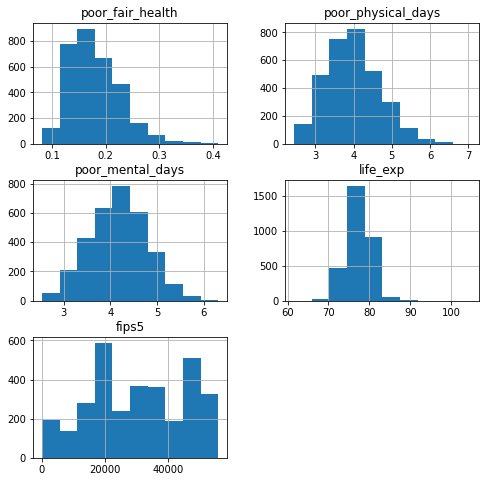

In [12]:
# Numeric column distribution
health_df[numeric_cols].hist(figsize=(8,8))
plt.show()

From the above graphs, the values for poor_mental_days roughly follow a normal distribution, and the ranges for poor_mental_days and poor_physical_days is roughly the same. However, the data values for poor_physical_days is slightly skewed right. The range on life expectancy is roughly 30 years, and has a distinct peak around 76 years old. Poor_fair_health is also skewed right. 

In [13]:
health_df[numeric_cols].describe().round(3)

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp,fips5
count,3194.000,3194.000,3194.000,3121.000,3194.000
mean,0.179,3.989,4.166,77.486,30351.417
std,0.047,0.703,0.602,3.026,15179.046
min,0.081,2.449,2.533,61.626,0.000
25%,0.143,3.473,3.747,75.571,18171.500
50%,0.172,3.935,4.171,77.510,29174.000
75%,0.209,4.439,4.574,79.369,45074.500
max,0.410,7.062,6.314,104.740,56045.000


In [14]:
health_df.set_index('name')[numeric_cols].aggregate(['idxmin', 'idxmax'])

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp,fips5
idxmin,Douglas County,Carver County,Aleutians West Census Area,Buffalo County,United States
idxmax,Zavala County,Kusilvak Census Area,McDowell County,San Miguel County,Weston County


In [15]:
# checking whether taking mean of country rows grouped by state
# matches the equivalent row for the state

In [16]:
state_means_df=health_df[-state_filter].groupby('state_abbreviation')[numeric_cols].mean()

In [17]:
state_means_df.loc['AL']

poor_fair_health         0.238164
poor_physical_days       4.960199
poor_mental_days         4.966114
life_exp                74.644740
fips5                 1067.000000
Name: AL, dtype: float64

In [18]:
health_df.head()

,state_fips,county_fips,fips5,state_abbreviation,name,poor_fair_health,poor_physical_days,poor_mental_days,life_exp,ratio_population_to_physicians,physicians_to_population,income_inequality
1,0,0,0,US,United States,0.171987,3.752828,3.970321,79.089130,1325.09053,0.000754665,4.920017801
2,1,0,1000,AL,Alabama,0.220287,4.918052,4.939753,75.416194,1542.641456,0.000648239,5.26113574
3,1,1,1001,AL,Autauga County,0.208830,4.743889,4.654031,76.879477,2220.16,0.000450418,5.234597269
4,1,3,1003,AL,Baldwin County,0.175091,4.224519,4.304056,78.450258,1371.793548,0.000728973,4.417766679
5,1,5,1005,AL,Barbour County,0.295918,5.430279,5.185594,75.341935,3158.75,0.000316581,5.681410019


In [19]:
health_df[health_df['fips5']== 1000][numeric_cols]

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp,fips5
2,0.220287,4.918052,4.939753,75.416194,1000


Save the data frame

In [20]:
health_df.to_csv(r'../data/health_clean.csv', index = False)

In [21]:
health_df_state = health_df.groupby('state_abbreviation')[['poor_fair_health', 'poor_physical_days', 'poor_mental_days', 'life_exp']].mean()

In [22]:
health_df_state.head()

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp
state_abbreviation,,,,
AK,0.169534,3.951762,3.620085,78.080936
AL,0.237901,4.959580,4.965726,74.656085
AR,0.233016,4.767555,4.771253,74.919770
AZ,0.197933,4.311024,4.338000,78.607591
CA,0.162036,3.740474,3.942800,80.330312


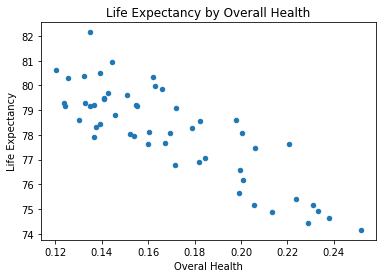

In [23]:
health_df_state.plot(kind='scatter', 
                     x = 'poor_fair_health', 
                     y = 'life_exp')
plt.xlabel("Overal Health")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy by Overall Health")
plt.show()

In [24]:
health_df_state[['poor_fair_health', 'life_exp']].corr()

,poor_fair_health,life_exp
poor_fair_health,1.000000,-0.842367
life_exp,-0.842367,1.000000


There is a strong negative correlation between overall health and life expectancy. This is to be expected, as the greater the overal health value the worse average health is. Thus as life expectancy increases overall health also increases. Or equivanetly, as the proportion of the population who report poor health increases, the life expectancy in that state decreases.

In [25]:
health_df_state.abs().aggregate(['max', 'min'])

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp
max,0.251460,5.329252,5.376755,82.150719
min,0.120379,2.885692,3.136575,74.155815


In [26]:
health_df_state.abs().aggregate(['idxmax', 'idxmin'])

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp
idxmax,MS,WV,WV,HI
idxmin,CT,DC,SD,MS


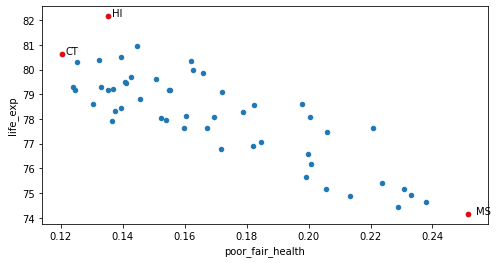

In [27]:
states_to_highlight = ['MS', 'CT', 'HI']

splot = health_df_state.abs().plot(kind='scatter', 
                     x = 'poor_fair_health', 
                     y = 'life_exp',
                     figsize=(8,4)
                                  )

highlights = health_df_state.abs().loc[states_to_highlight]


highlights.plot(kind='scatter',
                x = 'poor_fair_health', 
                y = 'life_exp',
                color='red',
                ax=splot
)

highlights.reset_index().apply(lambda r: plt.text(r['poor_fair_health']*1.01,
                                    r['life_exp'],
                                    r['state_abbreviation']
                                   ), axis=1)

plt.show()

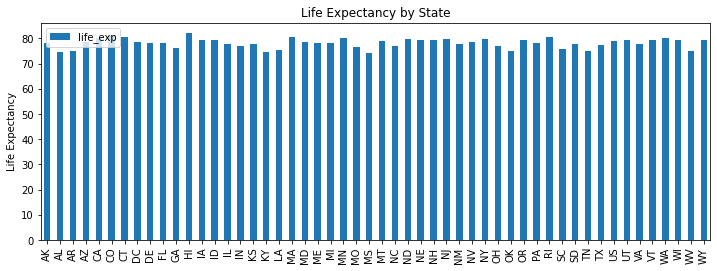

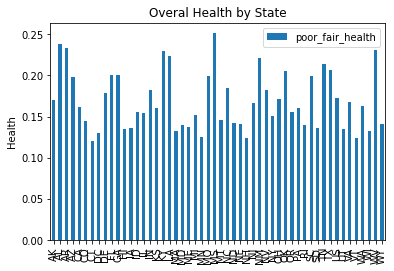

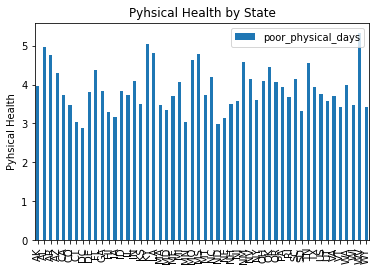

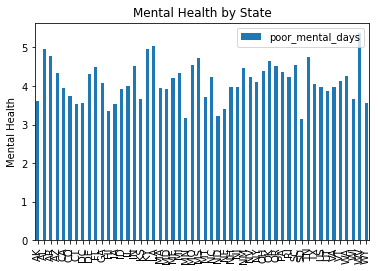

In [28]:
#plt.rcParams["figure.figsize"]=12,4

# can reset with
# plt.rcParams.setdefault("figure.figsize")

health_df_state.plot(kind='bar', 
                     y = 'life_exp',
                     figsize=(12,4)    # change the size of figure
                                       # on a plot basis not defaults
                    )

plt.xlabel("")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy by State")
plt.xticks(rotation = 90)
plt.show()
health_df_state.plot(kind='bar', y = 'poor_fair_health')
plt.xlabel("")
plt.ylabel("Health")
plt.title("Overal Health by State")
plt.xticks(rotation = 90)
plt.show()
health_df_state.plot(kind='bar', y = 'poor_physical_days')
plt.xlabel("")
plt.ylabel("Pyhsical Health")
plt.title("Pyhsical Health by State")
plt.xticks(rotation = 90)
plt.show()
health_df_state.plot(kind='bar', y = 'poor_mental_days')
plt.xlabel("")
plt.ylabel("Mental Health")
plt.title("Mental Health by State")
plt.xticks(rotation = 90)
plt.show()

From the four plots above, overall life expectancy does not seem to differ much between states. However, overall health, mental health, and physical health have larger ranges. 

# Step 2

## Questions
* What is the relation between overall health, mental health, physical health, and life expectancy?
* Do any states stand out as having particually high/low health?

## Steps:
* Q1
    * Create a geoplot for all variables, and see if the geoplot shows any correlation.
    * Create a scatter plot comparing overal health to mental health, physical health, and life expectancy 
    * Look at the coorelation between the varaiables
    * Initially expect a positve relation between all measures except for life expactency, as all other measures are for bad health. 
* Q2
    * Group the data by state 
    * plot the measures in a bar chart
    * see if any one state stands out

### Geoplots

In [29]:
# source 
# https://github.com/deldersveld/topojson/tree/master/countries/united-states
us_map_gdf = gpd.read_file('../data/us_counties_albers.geojson')
us_map_gdf['fips']=us_map_gdf['fips'].astype(int)

In [30]:
health_gdf = pd.merge(us_map_gdf,
         health_df,
         left_on='fips',
         right_on='fips5'
        )

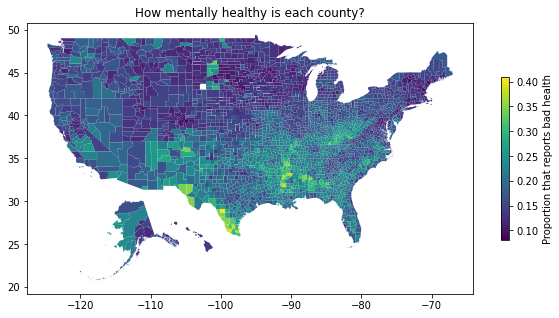

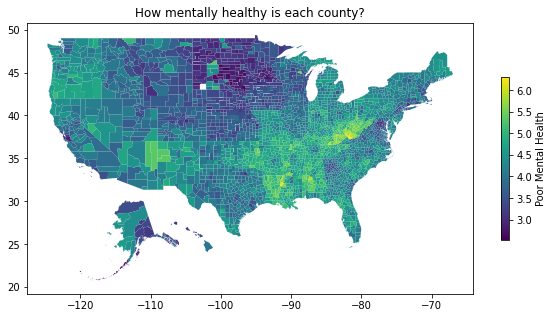

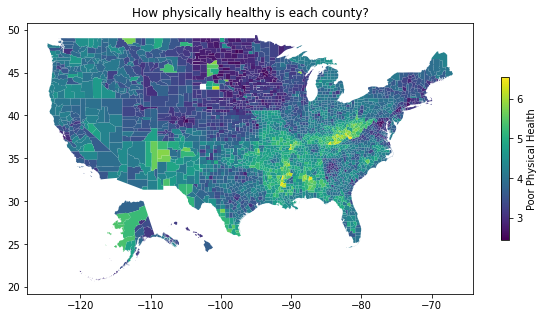

In [31]:
health_gdf.plot(column='poor_fair_health', 
                       legend=True,
                       figsize=(10,10),
                       legend_kwds={'shrink': 0.3,
                                    'label': 'Proportion that reports bad health'
                                   }
                      )

plt.title("How mentally healthy is each county?")
plt.show()

health_gdf.plot(column='poor_mental_days', 
                       legend=True,
                       figsize=(10,10),
                       legend_kwds={'shrink': 0.3,
                                    'label': 'Poor Mental Health'
                                   }
                      )

plt.title("How mentally healthy is each county?")
plt.show()

health_gdf.plot(column='poor_physical_days', 
                       legend=True,
                       figsize=(10,10),
                       legend_kwds={'shrink': 0.3,
                                    'label': 'Poor Physical Health'
                                   }
                      )

plt.title("How physically healthy is each county?")
plt.show()

From the geoplot it seems that overall the southern states have poorer health. Additioanlly the geoplots for mental and physical health look almost the same. This shows a high correlation between the two measures. 

### Question 1

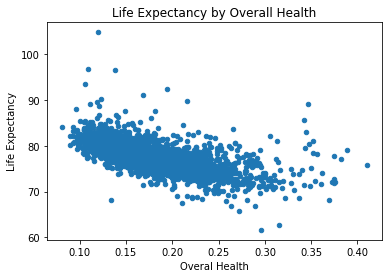

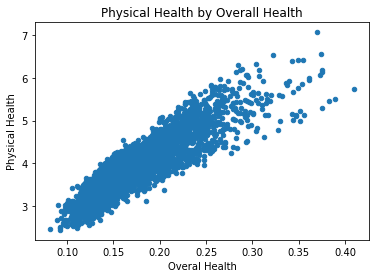

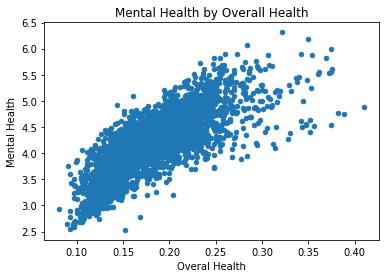

In [32]:
health_df[-state_filter].plot(kind='scatter', x = 'poor_fair_health', y = 'life_exp')
plt.xlabel("Overal Health")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy by Overall Health")
plt.show()
health_df[-state_filter].plot(kind='scatter', x = 'poor_fair_health', y = 'poor_physical_days')
plt.xlabel("Overal Health")
plt.ylabel("Physical Health")
plt.title("Physical Health by Overall Health")
plt.show()
health_df[-state_filter].plot(kind='scatter', x = 'poor_fair_health', y = 'poor_mental_days')
plt.xlabel("Overal Health")
plt.ylabel("Mental Health")
plt.title("Mental Health by Overall Health")
plt.show()

In [33]:
health_df[['poor_fair_health', 'life_exp', 
           'poor_physical_days','poor_mental_days']].corr()

,poor_fair_health,life_exp,poor_physical_days,poor_mental_days
poor_fair_health,1.000000,-0.645189,0.891073,0.780832
life_exp,-0.645189,1.000000,-0.679527,-0.654201
poor_physical_days,0.891073,-0.679527,1.000000,0.933549
poor_mental_days,0.780832,-0.654201,0.933549,1.000000


#### Answer and Interpretation/Observation
The outcomes are as expected. Overall health has a strong positive correlation to mental and physical health, and a negative correlation to life expectancy. That is to say as overall health increases (numeric value decreaes), physical health, mental health, and life expectancy all increase as well. From the correlation table, physical and mental health share the highest correlation. This is expected and was apparent from the geoplots of mental and physical health. 

### Question 2

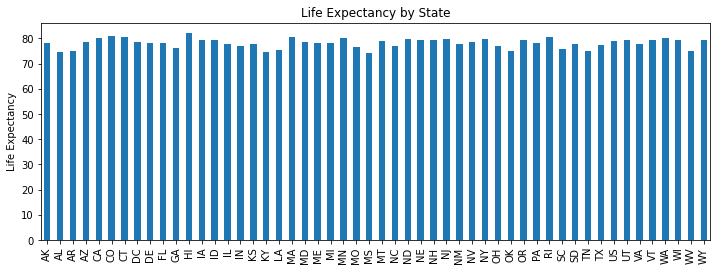

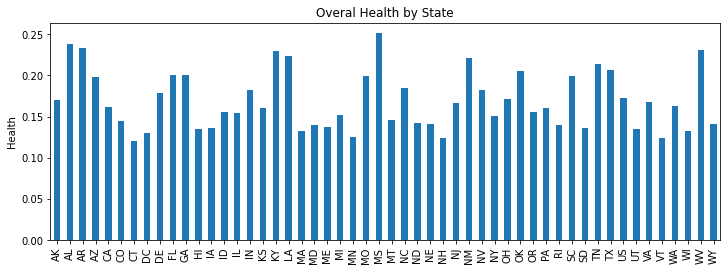

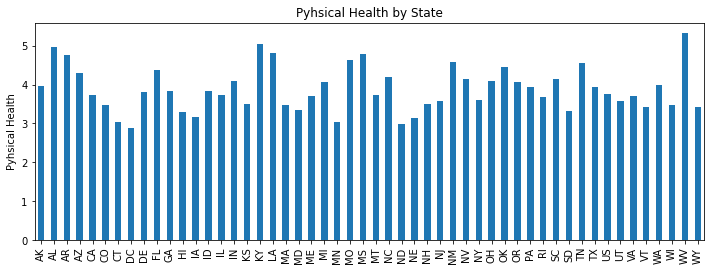

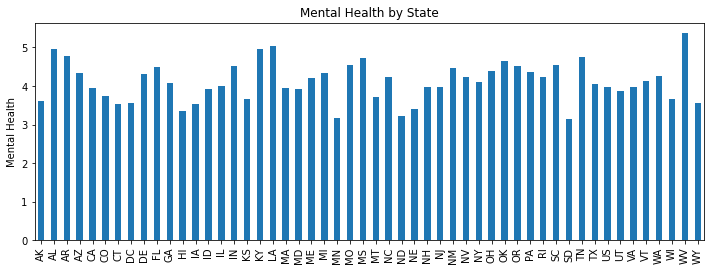

In [34]:
plt.rcParams["figure.figsize"]=12,4

health_df_state.plot(kind='bar', y = 'life_exp')

plt.xlabel("")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy by State")
plt.xticks(rotation = 90)
plt.legend().remove()
plt.show()
health_df_state.plot(kind='bar', y = 'poor_fair_health')
plt.xlabel("")
plt.ylabel("Health")
plt.title("Overal Health by State")
plt.xticks(rotation = 90)
plt.legend().remove()
plt.show()
health_df_state.plot(kind='bar', y = 'poor_physical_days')
plt.xlabel("")
plt.ylabel("Pyhsical Health")
plt.title("Pyhsical Health by State")
plt.xticks(rotation = 90)
plt.legend().remove()
plt.show()
health_df_state.plot(kind='bar', y = 'poor_mental_days')
plt.xlabel("")
plt.ylabel("Mental Health")
plt.title("Mental Health by State")
plt.xticks(rotation = 90)
plt.legend().remove()
plt.show()

In [35]:
health_df_state.abs().aggregate(['max', 'min'])

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp
max,0.251460,5.329252,5.376755,82.150719
min,0.120379,2.885692,3.136575,74.155815


In [36]:
health_df_state.abs().aggregate(['idxmax', 'idxmin'])

,poor_fair_health,poor_physical_days,poor_mental_days,life_exp
idxmax,MS,WV,WV,HI
idxmin,CT,DC,SD,MS


#### Answer and Interpretation/Observation
No state particually stands out in regards to life expectancy. However, West Virginia has the poorest average mental and physical health (it is not surprising that the same state has the poorest mental and physical health given the high correlation between the too seen in question 1). Additionally, Mississippi has the poorest overall health. Hawaii has the highest life expectancy at 82 years old, while Mississippi has the lowest life_expectancy and the lowest overall health. Connecticut has the best overall health. West Virginia has the worst physical and mental health. DC has the best physical health, and South Dakota has the best mental health. 